In [37]:
import torch
import torch.nn.functional as f
from torchvision import datasets, transforms
import torch.nn
import utils
import matplotlib.pyplot as plt


from model import get_model

device = torch.device("cpu")

In [8]:
import zipfile

# Extract the zip file
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("File extracted successfully!")

File extracted successfully!


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),])

subset_size = 256
print(f"Evaluating on the first {subset_size} MNIST test samples")

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(subset_size))
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=subset_size, shuffle=False)

x_test, y_test = next(iter(test_loader))
x_test = x_test.view(x_test.size(0), -1).to(device)
y_test = y_test.to(device)

print(f"Loaded {x_test.shape[0]} samples")
print(f"Flattened dimension: {x_test.shape[1]}")
print(f"Data range: {x_test.min():.3f} to {x_test.max():.3f}")

Evaluating on the first 256 MNIST test samples
Loaded 256 samples
Flattened dimension: 784
Data range: 0.000 to 1.000


In [10]:
model = get_model(pretrained_path="data/model.pth", device=device)
clean_accuracy = utils.accuracy(model, x_test, y_test)


In [12]:
attack_results = {}

def clamp_unit(x):
    return torch.clamp(x, 0.0, 1.0)

def project_linf(delta, eps):
    return torch.clamp(delta, -eps, eps)

def compute_attack_metrics(x_adv, x_clean=x_test, y_clean=y_test):
    with torch.no_grad():
        adv_logits = model(x_adv)
        adv_preds = adv_logits.argmax(dim=1)
    adv_acc = (adv_preds == y_clean).float().mean().item()
    delta = x_adv - x_clean
    linf = delta.abs().max(dim=1)[0].mean().item()
    l2 = torch.norm(delta, p=2, dim=1).mean().item()
    return adv_acc, linf, l2

def log_attack(name, x_adv, notes=None):
    adv_acc, linf, l2 = compute_attack_metrics(x_adv)
    attack_results[name] = {
        "clean_acc": clean_accuracy,
        "adv_acc": adv_acc,
        "avg_linf": linf,
        "avg_l2": l2,
        "notes": notes or ""
    }
    print(f"{name} -> adv accuracy: {adv_acc:.4f} | mean L_inf: {linf:.4f} | mean L2: {l2:.4f}")

def visualize_examples(name, x_adv, num_examples=5):
    num_examples = min(num_examples, x_adv.size(0))
    clean_imgs = x_test[:num_examples].detach().cpu().reshape(-1, 28, 28)
    adv_imgs = x_adv[:num_examples].detach().cpu().reshape(-1, 28, 28)
    diff = adv_imgs - clean_imgs
    vmax = diff.abs().max().item() or 1.0
    fig, axes = plt.subplots(3, num_examples, figsize=(num_examples * 2.2, 6))
    for idx in range(num_examples):
        axes[0, idx].imshow(clean_imgs[idx], cmap="gray")
        axes[0, idx].set_title(f"Clean {idx}")
        axes[0, idx].axis("off")

        axes[1, idx].imshow(adv_imgs[idx], cmap="gray")
        axes[1, idx].set_title("Adv")
        axes[1, idx].axis("off")

        axes[2, idx].imshow(diff[idx], cmap="seismic", vmin=-vmax, vmax=vmax)
        axes[2, idx].set_title("Perturb")
        axes[2, idx].axis("off")
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()

#IMPLEMENTING FAST GRADIENT SIGN METHOD - FGSM

In [33]:
epsilon = 0.03
def fgsm_attack(model, x, y, eps):
  x_adv = x.clone().detach().to(device).requires_grad_(True)
  y = y.to(device)
  logits = model(x_adv)
  loss = f.cross_entropy(logits, y)
  loss.backward()
  model.zero_grad()
  grad_sign = x_adv.grad.data.sign()
  x_adv = x_adv + eps * grad_sign
  x_adv = torch.clamp(x_adv, 0.0, 1.0 )

  return x_adv.detach()

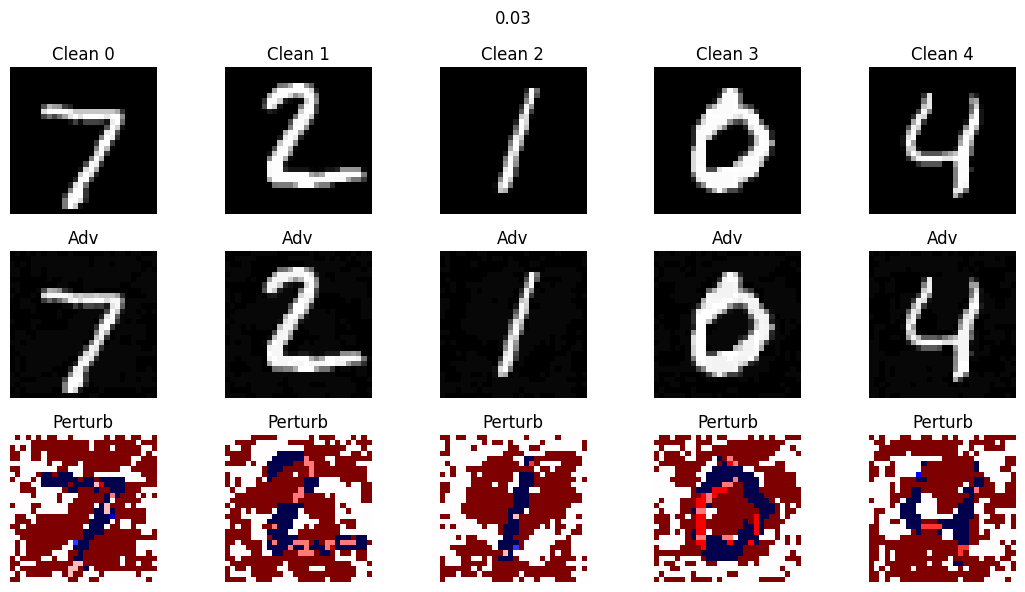

In [38]:
x_adv_fgsm_attack = fgsm_attack(model, x_test, y_test, epsilon)
visualize_examples(epsilon, x_adv_fgsm_attack)
